# Time-Independent Perturbation Theory

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Infinite 1D Square Well

Consider the potential:
$$
V(x) = \begin{cases}
0 & 0 \le x \le a \\
\infty & \text{otherwise}
\end{cases}
$$
with stationary states ($n = 1, 2, 3, \ldots$):
$$
\psi_n(x) = \sqrt{\frac{2}{a}}\, \sin\left( \frac{n\pi}{a} x\right)
$$
and corresponding energies:
$$
E_n = n^2 E_1 \; .
$$

Plot the lowest-energy stationary states:

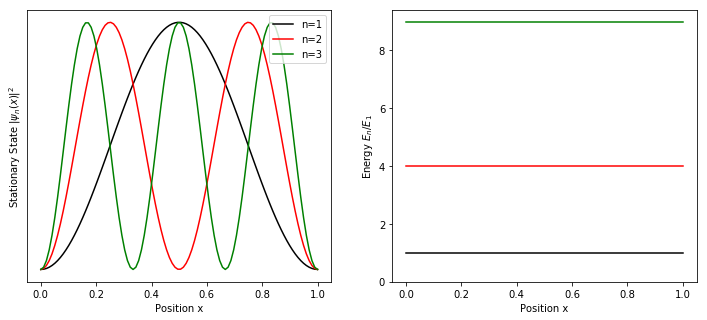

In [2]:
def plot_1d_unperturbed(a=1, nmax=3, ngrid=100):
    x = np.linspace(0, a, ngrid)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for n in range(1, nmax + 1):
        color = 'krgb'[n - 1]
        psi = np.sqrt(2 / a) * np.sin(n * np.pi * x / a)
        ax[0].plot(x, psi ** 2, c=color, label=f'n={n}')
        ax[1].plot([0, a], [n ** 2, n ** 2], c=color, label=f'n={n}')
    ax[0].set_yticks([])
    ax[0].legend()
    ax[0].set_xlabel('Position x')
    ax[0].set_ylabel('Stationary State $|\psi_n(x)|^2$')
    ax[1].set_ylim(0, None)
    ax[1].set_xlabel('Position x')
    ax[1].set_ylabel('Energy $E_n / E_1$')
    
plot_1d_unperturbed()

Calculate corrections when the potential is perturbed with the addition of:
$$
H' = 
\begin{cases}
\delta V  & u \le x \le v \\
0 & \text{otherwise}
\end{cases}
$$
The first-order correction to the energy is:
$$
E_n^1 = \langle \psi_n^0\mid H'\mid \psi_n^0\rangle
= \delta V \int_u^v \left| \psi_n(x)\right|^2 dx
$$
with
$$
\int_u^v \left| \psi_n(x)\right|^2 dx = \frac{1}{2 a n\pi} \left[
2(v - u) n \pi + a \sin(2 u n\pi/a) - a \sin(2 v n\pi/a)\right] \; .
$$
The corresponding first-order correction to the stationary state is:
$$
\psi_n^1 = \sum_{k\ne n} c_k^{(n)} \psi_n^0
$$
with
$$
c_k^{(n)} = \frac{\langle \psi_k^0\mid H'\mid \psi_n^0\rangle}{E_n^0 - E_k^0} = \frac{\delta V}{E_n^0 - E_k^0}
\int_u^v \psi_k(x)^\ast \psi_n(x) dx
$$
and
$$
\int_u^v \psi_k(x)^\ast \psi_n(x) dx = \frac{1}{(k^2 - n^2)\pi}\bigl[
n \left(\cos n\pi v/a \sin k\pi v/a - \cos n\pi u/a \sin k\pi u/a\right) +
k \left(\cos k\pi u/a \sin n\pi u/a - \cos k\pi v/a \sin n\pi v/a\right)\bigr] \; .
$$
The second-order correction to the energy is:
$$
E_n^2 = \sum_{k\ne n} \frac{\left|\langle \psi_k^0\mid H'\mid \psi_n^0\rangle\right|^2}{E_n^0 - E_k^0}
= \delta V^2 \sum_{k\ne n}\frac{\left[\int_u^v \psi_k(x)^\ast \psi_n(x) dx\right]^2}{E_n^0 - E_k^0} \; .
$$

Note that when $u=0$ and $v=a$, these simplify to:
$$
E_n^1 = \delta V \quad , \quad
c_k^{(n)} = 0 \quad , \quad
E_n^2 = 0 \; .
$$

In [3]:
def get_matrix(u, v, nmax=10, a=1):
    n = np.arange(1, nmax + 1)
    npi = n * np.pi / a
    Hp = np.diag((2 * (v - u) * npi + np.sin(2 * u * npi) - np.sin(2 * v * npi)) / (2 * a * npi))
    for k in n:
        kpi = k * np.pi / a
        num = (
            n * (np.cos(npi * v) * np.sin(kpi * v) - np.cos(npi * u) * np.sin(kpi * u)) +
            k * (np.cos(kpi * u) * np.sin(npi * u) - np.cos(kpi * v) * np.sin(npi * v)))
        Hp[k - 1, k != n] = num[k != n] / (np.pi * (k ** 2 - n ** 2)[k != n])
    return n, Hp

In [4]:
def plot_matrix(u, v, nmax=20, a=1):
    n, Hp = get_matrix(u, v, nmax, a)
    fig, ax = plt.subplots(1, 2, figsize=(13.5, 5))
    vlim = np.max(np.abs(Hp))
    I = ax[0].imshow(Hp, interpolation='none', vmax=+vlim, vmin=-vlim, cmap='bwr')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.colorbar(I, ax=ax[0]).set_label('Matrix element $H\prime_{kn}$')
    k = n.copy()
    ck = np.zeros_like(Hp)
    for k in n:
        ck[k - 1, k != n] = Hp[k - 1, k != n] / (k ** 2 - n ** 2)[k != n]
    vlim = max(1e-8, np.max(np.abs(ck)))
    I = ax[1].imshow(ck, interpolation='none', vmax=+vlim, vmin=-vlim, cmap='bwr')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.colorbar(I, ax=ax[1]).set_label('$\psi_n^1$ coeffcient $c_k^{(n)}$') 

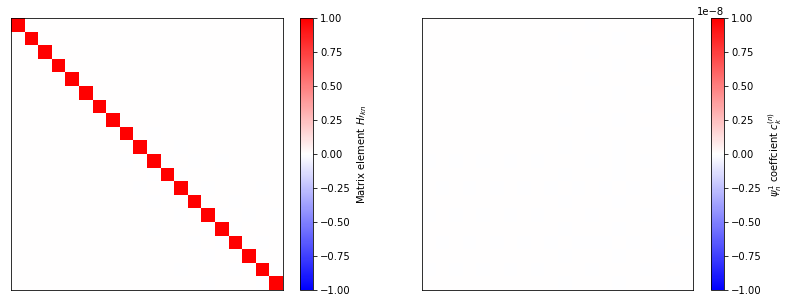

In [5]:
plot_matrix(0, 1)

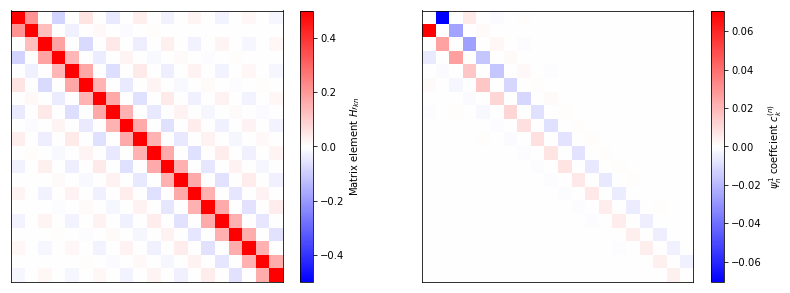

In [6]:
plot_matrix(0, 0.5)

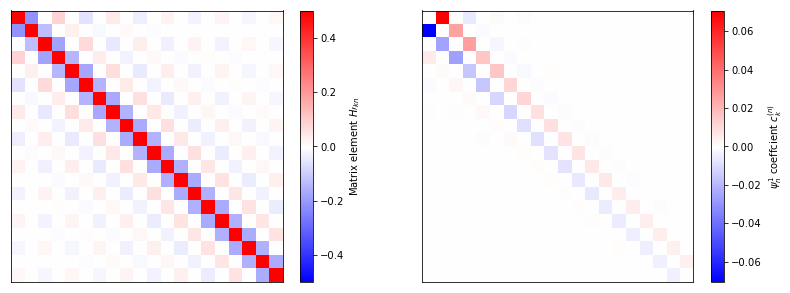

In [7]:
plot_matrix(0.5, 1)

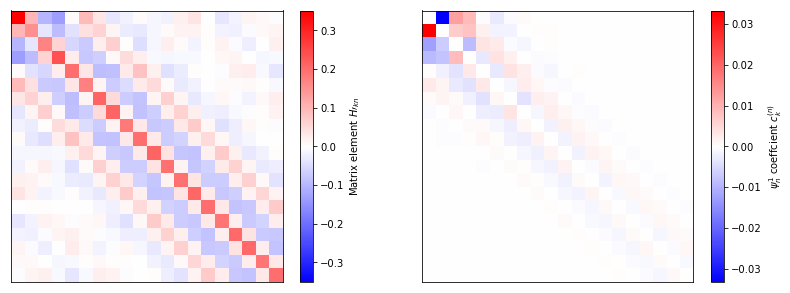

In [8]:
plot_matrix(0.3, 0.5)

In [9]:
def solve_perturb(u, v, n, dV=1, kmax=100, a=1, nx=100):
    # Calculate the 0th order energy.
    En0 = n ** 2
    # Calculate 1st order correction to the energy
    npi = n * np.pi / a
    En1 = (2 * (v - u) * npi + np.sin(2 * u * npi) - np.sin(2 * v * npi)) * dV / (2 * a * npi)
    # Calculate 2nd order correction to the energy
    k = np.arange(1, kmax + 1)
    kpi = k * np.pi / a
    dotp = (n * (np.cos(npi * v) * np.sin(kpi * v) - np.cos(npi * u) * np.sin(kpi * u)) +
            k * (np.cos(kpi * u) * np.sin(npi * u) - np.cos(kpi * v) * np.sin(npi * v)))
    dotp[k != n] /= (np.pi * (k ** 2 - n ** 2)[k != n])
    En0 = n ** 2
    Ek0 = k ** 2
    En2 = np.sum(dotp[k != n] ** 2 / (En0 - Ek0)[k != n]) * dV ** 2
    # Calculate coefficients of the 1st order correction to the stationary state.
    ck = dV * dotp
    ck[k != n] /= (En0 - Ek0)[k != n]
    # Build 0th and 1st order solutions.
    x = np.linspace(0, a, nx).reshape(-1, 1)
    psin0 = np.sqrt(2 / a) * np.sin(npi * x).reshape(-1)
    psin1 = np.sum(ck[k != n] * np.sqrt(2 / a) * np.sin(kpi[k != n] * x), axis=1)
    return En0, En1, En2, x.reshape(-1), psin0, psin1

In [10]:
def plot_perturb(u, v, n, dVmax=10):
    En0, En1, En2, x, psin0, psin1 = solve_perturb(u, v, n)
    ngrid = 6
    dVgrid = np.linspace(0, dVmax, ngrid)
    fig, ax = plt.subplots(1, 2, figsize=(13.5, 5))
    sel = (x >= u) & (x < v)
    colors = np.zeros((len(dVgrid), 4))
    colors[:, 3] = np.linspace(1, 0.5, ngrid)
    colors[:, 0] = np.linspace(0, 1, ngrid) ** 2
    for dV, color in zip(dVgrid, colors):
        psisq = (psin0 + dV * psin1) ** 2
        psisq /= np.trapz(psisq, x)
        if dV == 0:
            norm = dVmax / np.max(psisq)
        psisq *= norm
        ax[0].plot(x, psisq, c=color, lw=2, label=f'$\delta V = {dV}$')
        ax[0].plot(x[sel], dV + 0 * x[sel], c=color, lw=1)
    ax[0].set_xlabel('Position $x$')
    ax[0].set_ylabel(f'Perturbed $V(x)$, $|\psi_{n}^1(x)|^2$')
    
    ax[1].plot(dVgrid, En0 + 0 * dVgrid, 'k-', label='0th order')
    ax[1].plot(dVgrid, En0 + dVgrid * En1, 'k--', label='1st order')
    ax[1].plot(dVgrid, En0 + dVgrid * En1 + dVgrid ** 2 * En2, 'k:', label='2nd order')
    ax[1].scatter(dVgrid, En0 + dVgrid * En1 + dVgrid ** 2 * En2, lw=0, c=colors, s=50)
    ax[1].scatter(dVgrid, dVgrid, c='b', marker='*', s=50, label='$\delta V$')
    ax[1].legend()
    ax[1].set_xlabel('Perturbation Strength $\delta V$')
    ax[1].set_ylabel(f'Perturbed Energy $E_{n}^m$')

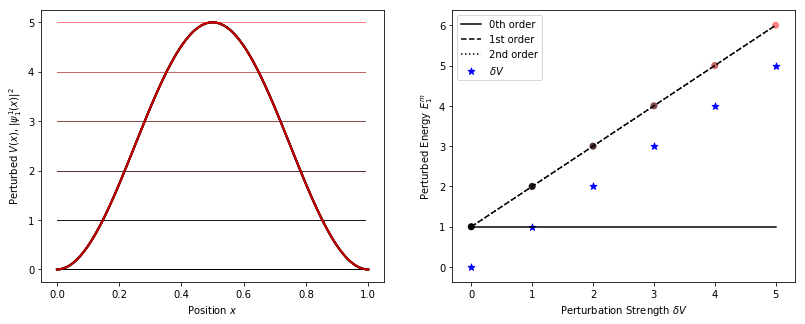

In [11]:
plot_perturb(0, 1, 1, 5)

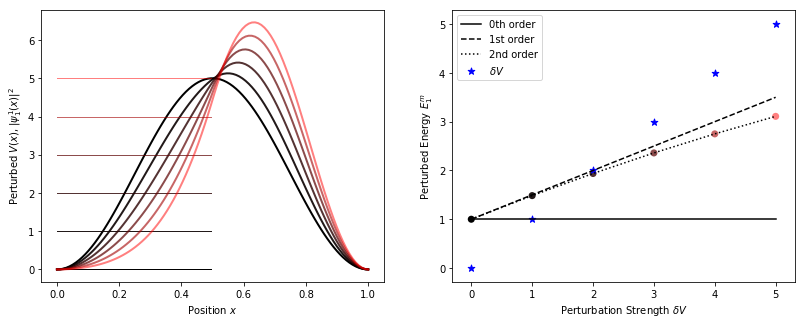

In [12]:
plot_perturb(0, 0.5, 1, 5)

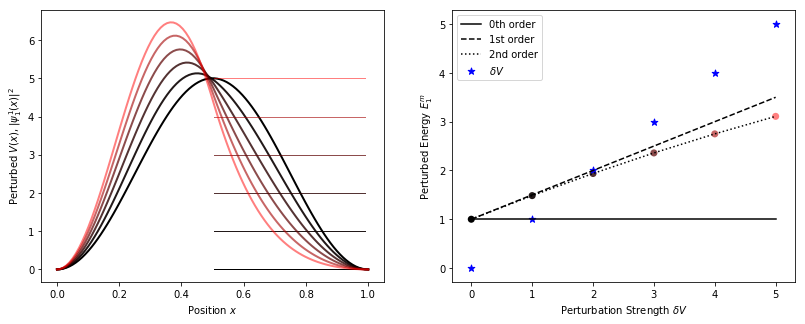

In [13]:
plot_perturb(0.5, 1, 1, 5)

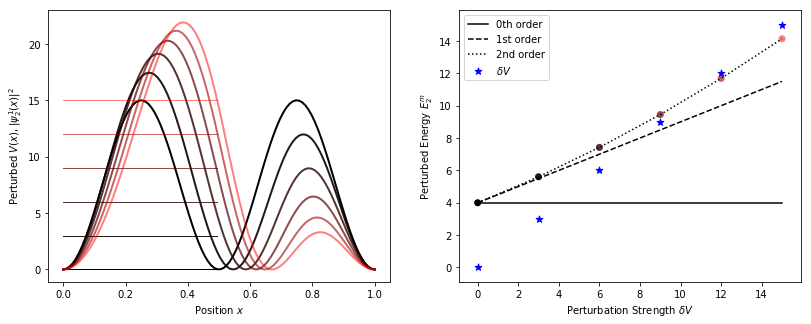

In [14]:
plot_perturb(0, 0.5, 2, 15)

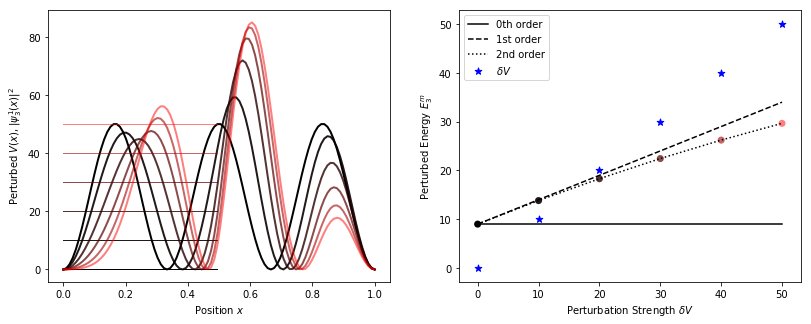

In [15]:
plot_perturb(0, 0.5, 3, 50)

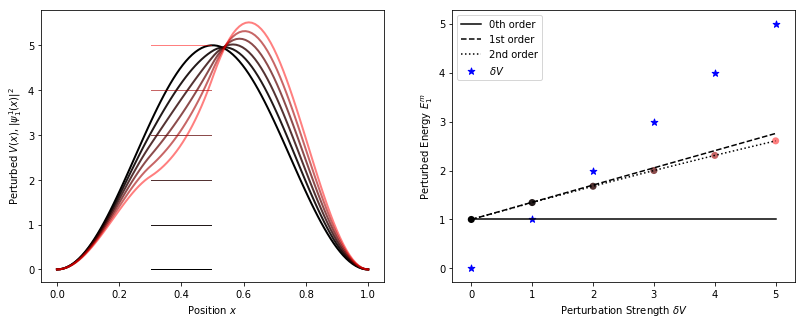

In [16]:
plot_perturb(0.3, 0.5, 1, 5)

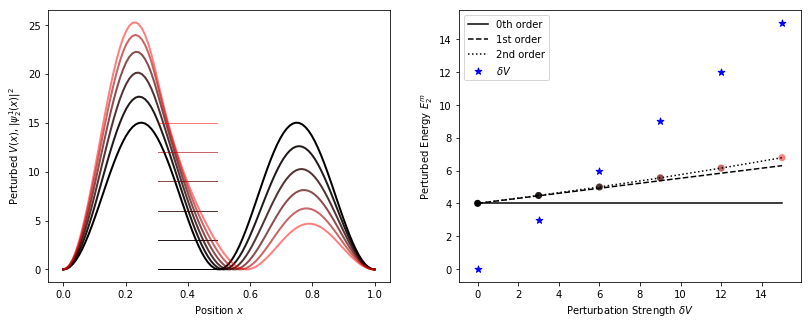

In [17]:
plot_perturb(0.3, 0.5, 2, 15)

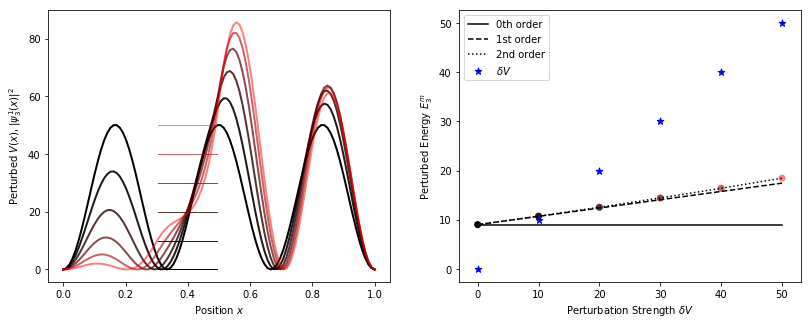

In [18]:
plot_perturb(0.3, 0.5, 3, 50)